In [1]:
import os
import re
import sys
from collections import Counter
from glob import glob
from pathlib import Path

import matplotlib.pyplot as plt
import nibabel as nib
import numpy as np
import pandas as pd
from nilearn import plotting
from nilearn.image import smooth_img
from nilearn.input_data import NiftiMasker

%load_ext autoreload
%autoreload 2

from delay_discounting_mvpa.config_loader import load_config

/tmp/ipykernel_10231/1314523419.py:14: DeprecationWarning: The import path 'nilearn.input_data' is deprecated in version 0.9. Importing from 'nilearn.input_data' will be possible at least until release 0.13.0. Please import from 'nilearn.maskers' instead.
  from nilearn.input_data import NiftiMasker


## Goal
As a reality check, I'd like to compare the standard choice comparison (Larger Later - Smaller Sooner) developed using the beta series estimates resembles the standard analyses.

Note:  I'm about to refactor the analysis directories, so the path to the comparative map may change (the standard analysis)

In [2]:
config_file = '/oak/stanford/groups/russpold/data/uh2/aim1/analysis_code/delay_discounting_mvpa/configs/config.yaml'
cfg = load_config(config_file)

In [3]:
beta_series_dir = cfg.output_root / 'lsa_estimates'

In [4]:
cfg

Config(data_root=PosixPath('/oak/stanford/groups/russpold/data/uh2/aim1'), fmriprep_dir=PosixPath('/oak/stanford/groups/russpold/data/uh2/aim1/derivatives/fmriprep'), bids_dir=PosixPath('/oak/stanford/groups/russpold/data/uh2/aim1/BIDS'), output_root=PosixPath('/oak/stanford/groups/russpold/data/uh2/aim1/derivatives/delay_discounting_mvpa'), task_name='discountFix', bold_func_glob='ses*/func/', bold_data_suffix='*MNI152NLin2009cAsym_desc-preproc_bold.nii.gz', mask_data_suffix='*MNI152NLin2009cAsym_desc-brain_mask.nii.gz', behav_func_glob='ses*/func/', behav_data_suffix='*events.tsv', masks_dir=PosixPath('/oak/stanford/groups/russpold/data/uh2/aim1/derivatives/masks'), tr=0.68, bold_file_glob='ses*/func/*discountFix*MNI152NLin2009cAsym_desc-preproc_bold.nii.gz', bold_mask_file_glob='ses*/func/*discountFix*MNI152NLin2009cAsym_desc-brain_mask.nii.gz', behav_file_glob='ses*/func/*discountFix*events.tsv')

In [5]:
subids_txt_file = Path('../good_subjects/good_subids.txt')
with open(subids_txt_file, 'r') as f:
    subids = [line.strip() for line in f if line.strip()]


In [6]:
subid = subids[2]

sub_betas_path = beta_series_dir / f'sub-{subid}_beta_series.nii.gz'
sub_beta_labels_path = beta_series_dir / f'sub-{subid}_beta_labels.csv'

In [7]:
all_maps = []
for subid in subids:
    print(subid)
    sub_betas_path = beta_series_dir / f'sub-{subid}_beta_series.nii.gz'
    sub_beta_labels_path = beta_series_dir / f'sub-{subid}_beta_labels.csv'
    # Load data
    img = nib.load(sub_betas_path)
    data = img.get_fdata()  # shape: (x, y, z, time)
    labels = pd.read_csv(sub_beta_labels_path)

    # Get boolean masks for each condition
    mask_later = labels['beta_condition'] == 'larger_later'
    mask_sooner = labels['beta_condition'] == 'smaller_sooner'

    # Compute condition means (average across 4th dimension)
    mean_later = data[..., mask_later].mean(axis=3)
    mean_sooner = data[..., mask_sooner].mean(axis=3)

    # Compute the difference
    diff_map = mean_later - mean_sooner
    all_maps.append(diff_map)

s061
s130
s172
s192
s234
s251
s358
s373
s471
s483
s497
s512
s518
s524
s525
s526
s541
s546
s548
s549
s553
s554
s555
s556
s557
s561
s567
s568
s570
s573
s574
s577
s579
s581
s582
s583
s584
s585
s587
s589
s590
s591
s592
s593
s594
s595
s596
s597
s601
s602
s604
s606
s607
s609
s610
s611
s612
s613
s614
s615
s616
s617
s618
s621
s622
s623
s624
s626
s627
s628
s629
s631
s633
s634
s635
s636
s637
s638
s641
s642
s643
s644
s645
s648
s650


In [8]:
import gc

# del data, mean_later, mean_sooner
gc.collect()

72

In [9]:
print(len(all_maps))

data = np.stack(all_maps, axis=0)


85


In [10]:
# smooth the data

cut_coords = np.arange(-50, 81, 10)

smoothed_maps = []

for m in all_maps:
    # Create a NIfTI image for this map (use original affine)
    img_tmp = nib.Nifti1Image(m, img.affine)

    # Smooth with 5mm FWHM
    smoothed_img = smooth_img(img_tmp, fwhm=5)

    # Convert back to array, keep separate
    smoothed_maps.append(smoothed_img.get_fdata())

smoothed_maps = np.stack(smoothed_maps, axis=0)
n = smoothed_maps.shape[0]
mean_map_smoothed = np.mean(smoothed_maps, axis=0)
std_map_smoothed = np.std(smoothed_maps, axis=0, ddof=1)  # sample std

valid_smoothed = std_map_smoothed > 0
t_map_smoothed = np.zeros_like(mean_map_smoothed, dtype=np.float32)
t_map_smoothed[valid_smoothed] = mean_map_smoothed[valid_smoothed] / (
    std_map_smoothed[valid_smoothed] / np.sqrt(n)
)

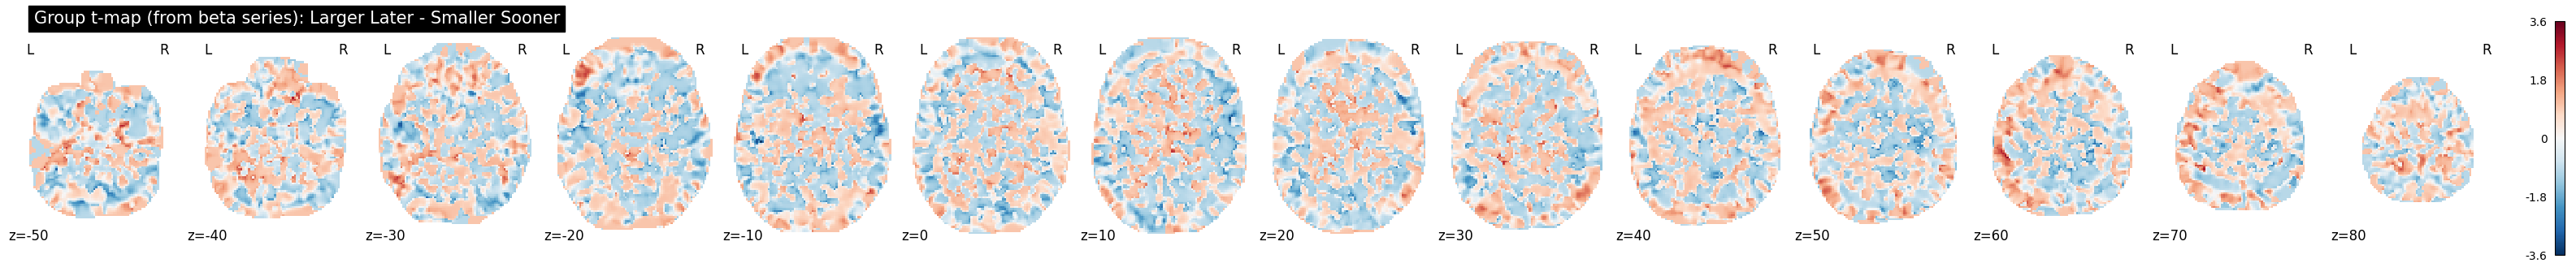

In [11]:
t_img_smoothed = nib.Nifti1Image(t_map_smoothed, img.affine, img.header)


# Plot thresholded at t > 2
plotting.plot_stat_map(
    t_img_smoothed,
    threshold=0,
    display_mode='z',  # sagittal, coronal, axial views
    cut_coords=cut_coords,
    colorbar=True,
    title='Group t-map (from beta series): Larger Later - Smaller Sooner',
)

plotting.show()

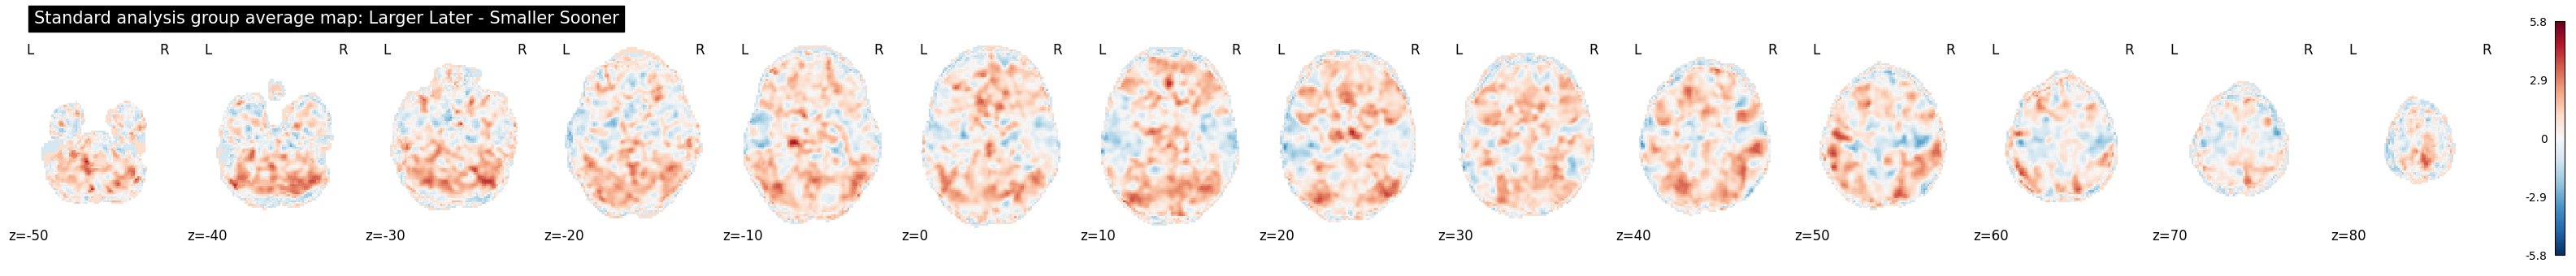

In [12]:
standard_tmap = Path(
    '/oak/stanford/groups/russpold/data/uh2/aim1_mumford/output/discountFix_lev2_output/discountFix_lev1_contrast_choice_rtmod_no_rt_lev2_model_one_sampt/randomise_output_model_one_sampt_tstat1.nii.gz'
)

plotting.plot_stat_map(
    standard_tmap,
    threshold=0,
    display_mode='z',  # sagittal, coronal, axial views
    cut_coords=cut_coords,
    colorbar=True,
    title='Standard analysis group average map: Larger Later - Smaller Sooner',
)

plotting.show()

In [13]:
# --- Load standard t-map ---
standard_tmap_img = nib.load(standard_tmap)

# --- Create masker from standard t-map ---
masker = NiftiMasker(mask_strategy='epi')  # uses nonzero voxels by default
masker.fit(standard_tmap_img)  # computes mask

# --- Extract masked data ---
standard_data = masker.transform(standard_tmap_img).ravel()  # 1D array of voxels
smoothed_data = masker.transform(t_img_smoothed).ravel()  # same mask applied


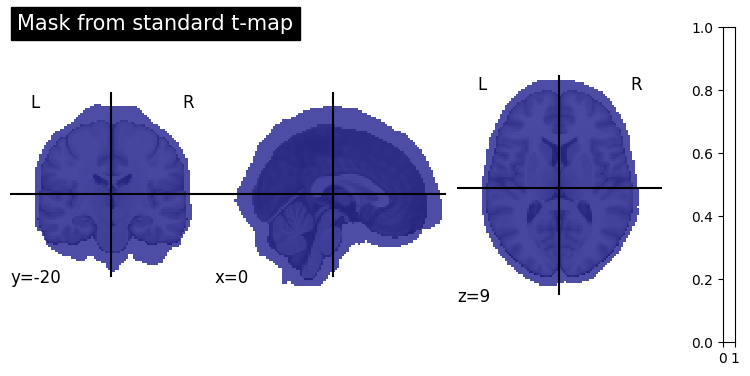

In [14]:
masker = NiftiMasker()
masker.fit(standard_tmap)

# Check the mask (decent enough)
plotting.plot_roi(masker.mask_img_, title='Mask from standard t-map')
plotting.show()

In [15]:
# --- Extract masked data ---
standard_data = masker.transform(standard_tmap_img).ravel()
smoothed_data = masker.transform(t_img_smoothed).ravel()

## Not a very good match between the two
I'm not totally surprised, but this doesn't bode well

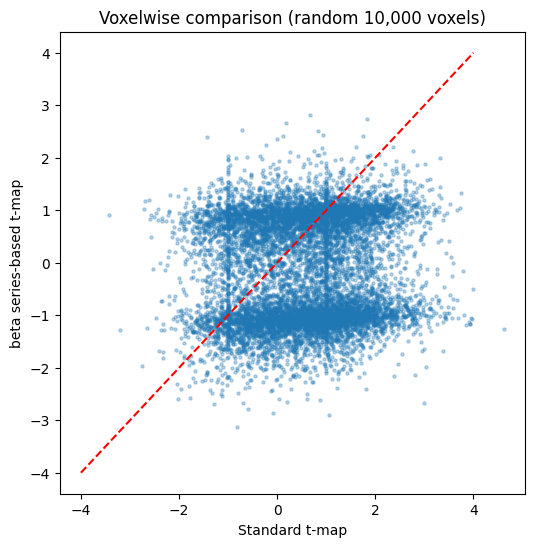

In [19]:
# --- Randomly select 10,000 voxels ---
n_vox = min(10000, len(standard_data))
idx = np.random.choice(len(standard_data), n_vox, replace=False)

standard_sample = standard_data[idx]
smoothed_sample = smoothed_data[idx]

range = 4


# --- Scatterplot ---
plt.figure(figsize=(6, 6))
plt.scatter(standard_sample, smoothed_sample, alpha=0.3, s=5)
plt.xlabel('Standard t-map')
plt.ylabel('beta series-based t-map')
plt.title('Voxelwise comparison (random 10,000 voxels)')
plt.plot([-range, range], [-range, range], 'r--')  # optional identity line
plt.show()
